# Unet

This page describes the implementation of the unet network architecture in Torch.

In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

test_picture = 500

## Data set

Will be used `OxfordIIITPet`. We will load it with `target_types = 'segmentation'` so for each picutre we will have picture itself and mask for it.

### Pictures

Here is an example of what we deal with as images.

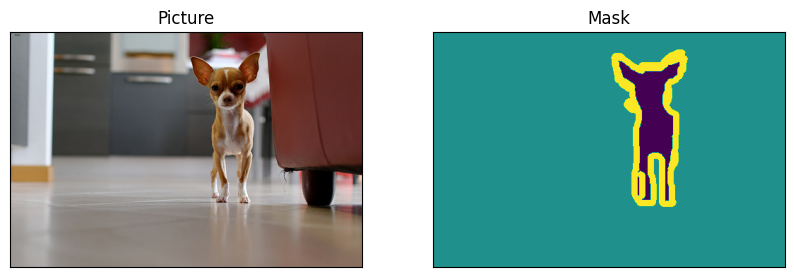

In [3]:
train_dataset = OxfordIIITPet(
    "OxfordIIITPet/", 
    target_types = "segmentation", 
    download = True
)
test_dataset = OxfordIIITPet(
    "OxfordIIITPet/", 
    target_types = "segmentation", 
    download = True,
    split = "test"
)

plt.figure(figsize = (10, 9))
plt.subplot(121)
plt.imshow(train_dataset[test_picture][0])
plt.xticks([]);plt.yticks([])
plt.title("Picture")

plt.subplot(122)
plt.imshow(train_dataset[test_picture][1])
plt.xticks([]);plt.yticks([])
plt.title("Mask")

plt.show()

### Transfomations

The network does not understand images. So we have to create tensors from images. Here we have added some transformations to our dataset. Let's see what they do.

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
target_transfrom = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.PILToTensor(),
    # classes are marked starting with 1
    # but in python it's easier to work with
    # with sets that start with 0, so the following
    # transformation fixes this inconvenience
    transforms.Lambda(lambda x: (x - 1).long())
])

transforms = (
    torchvision.datasets.
    vision.StandardTransform(transform, target_transfrom)
)

train_dataset.transforms = transforms
test_dataset.transforms = transforms

This is the shape of the tensor used as input to the model - it's regular three channel picture.

In [4]:
train_dataset[test_picture][0].shape

torch.Size([3, 256, 256])

This is the shape and unique values that appear in the target. So it's just an array whose shape is the same as the shape of the input images, but it only takes three values.

In [5]:
print("Shape:", list(train_dataset[test_picture][1].shape))
print("Values:", list(train_dataset[test_picture][1].unique()))

Shape: [1, 256, 256]
Values: [tensor(0), tensor(1), tensor(2)]


## Model

In [17]:
def train(
    model, device, optimizer, loss_fn, loader
) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(loader)
    accuracy = correct / total

    return train_loss, accuracy

In [7]:
def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 16

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)

        self.bottleneck = conv_plus_conv(base_channels * 2, base_channels * 2)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):

        residual1 = self.down1(x)
        x = self.downsample(residual1)

        residual2 = self.down2(x)
        x = self.downsample(residual2)

        x = self.bottleneck(x)
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual2), dim=1)
        x = self.up2(x)

        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual1), dim=1)
        x = self.up1(x)

        x = self.out(x)

        return x

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()
model = UNET().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)

cpu


In [ ]:
train(
    model = model,
    device = device,
    optimizer = optimizer,
    loss_fn = loss_fn,
    loader = train_loader
)